In [15]:
# !pip install catboost

In [188]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects

from sklearn.cluster import DBSCAN, KMeans

clusterization -> features (for every cluster): mean distance from the city centre within cluster, number of points in cluster, dispersion of distance between dotes in a cluster, number of boards oriented north, number of boards oriented west, другие меры центральной тенденции и изменчивости внутри кластеров

# Get Data

In [73]:
df = pd.read_json('train_data.json')

In [74]:
df

,hash,targetAudience,points,value
0,41567f28db47bee7,"{'name': 'All 25-45 BC', 'gender': 'all', 'age...","[{'lat': '55.573691', 'lon': '37.631423', 'azi...",23.51
1,94b6df335598a161,"{'name': 'W 30-60', 'gender': 'female', 'ageFr...","[{'lat': '55.656665886902', 'lon': '37.7408534...",1.20
2,2ef4e73f0d2c51d0,"{'name': 'W 30-60', 'gender': 'female', 'ageFr...","[{'lat': '55.680953807163', 'lon': '37.6644265...",4.65
3,b3ebb77f965de304,"{'name': 'W 30+ BC', 'gender': 'female', 'ageF...","[{'lat': '55.741072317672', 'lon': '37.6526972...",32.09
4,76059b6cbb303166,"{'name': 'W 30+ BC', 'gender': 'female', 'ageF...","[{'lat': '55.656665886902', 'lon': '37.7408534...",26.12
...,...,...,...,...
1542,75563c4cce5ca6c0,"{'name': 'All 30-55 BC', 'gender': 'all', 'age...","[{'lat': '55.961879', 'lon': '37.333988', 'azi...",20.55
1543,ed4353d7c33dd21c,"{'name': '35-100 C', 'gender': 'all', 'ageFrom...","[{'lat': '55.752846850282', 'lon': '37.5875834...",59.32
1544,77a82843b71a77ec,"{'name': '35-100 C', 'gender': 'all', 'ageFrom...","[{'lat': '55.752846850282', 'lon': '37.5875834...",41.30
1545,87b45be3fae91c39,"{'name': 'M 25-55 ', 'gender': 'male', 'ageFro...","[{'lat': '55.662899746091', 'lon': '37.4817413...",59.15


# Data Preprocessing

In [269]:
df_processed = (
    pd.concat([df, pd.json_normalize(df['targetAudience'])], axis=1)
    .drop(['targetAudience', 'id'], axis=1)
    .assign(num_points=lambda df_: df_['points'].apply(lambda l: len(l)))
    .assign(age_bound=lambda df_: df_['ageFrom'].astype(str) + '-' + df_['ageTo'].astype(str))
)

In [270]:
df_processed

hash  \
0     41567f28db47bee7   
1     94b6df335598a161   
2     2ef4e73f0d2c51d0   
3     b3ebb77f965de304   
4     76059b6cbb303166   
...                ...   
1542  75563c4cce5ca6c0   
1543  ed4353d7c33dd21c   
1544  77a82843b71a77ec   
1545  87b45be3fae91c39   
1546  464e9e7d315ba25d   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

# EDA

In [271]:
location_data = (
    pd.concat(
        [
            df_processed[['points', 'income', 'gender', 'age_bound']].explode("points").reset_index(drop=True),
            pd.json_normalize(df_processed[['points', 'income']].explode("points")['points'])
        ], axis=1
    )
    .drop(columns=['points'])
    .astype({"lat": "float", "lon": "float", "azimuth": "float"})
    .reset_index(drop=True)
).sample(10000)
location_data

,income,gender,age_bound,lat,lon,azimuth
124872,abc,all,25-45,55.716067,37.745525,154.0
82384,bc,all,18-55,55.754836,37.732467,75.0
97887,bc,all,25-45,55.751577,37.842921,358.0
75998,bc,all,25-55,55.823865,37.437628,113.0
74230,abc,all,25-60,55.917996,37.763324,233.0
...,...,...,...,...,...,...
471,abc,all,25-50,55.711966,37.672861,54.0
72308,bc,all,20-40,55.730948,37.673368,320.0
16819,bc,all,25-50,55.601712,37.507236,60.0
131489,bc,all,25-50,55.733908,37.456459,248.0


In [22]:
df['name'].value_counts()

All 18+                           294
All 25-50 BC                      143
All 25-45 BC                      106
All 30-55 BC                       98
ALL 25-55 BC                       70
                                 ... 
All 18-50                           1
ALL 18-54                           1
All 14-49                           1
All 25-55 leroy_2021_04_remont      1
All 35-70 BC                        1
Name: name, Length: 70, dtype: int64

Чаше всего замеры проводились для группы All 18+

## Gender distribution

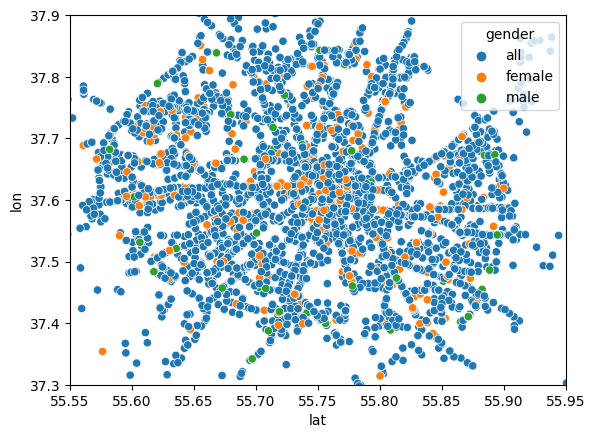

In [261]:
fig, ax = plt.subplots()
sns.scatterplot(
    x=location_data['lat'], y=location_data['lon'],
    ax=ax, hue=location_data['gender']
)
ax.set_ylim(37.3, 37.9)
ax.set_xlim(55.55, 55.95)
plt.show()

## Income breakdown

In [79]:
df_processed['income'].value_counts()

bc     877
abc    537
c      121
ab      11
ac       1
Name: income, dtype: int64

In [80]:
df_processed

,hash,points,value,name,gender,ageFrom,ageTo,income,num_points
0,41567f28db47bee7,"[{'lat': '55.573691', 'lon': '37.631423', 'azi...",23.51,All 25-45 BC,all,25,45,bc,25
1,94b6df335598a161,"[{'lat': '55.656665886902', 'lon': '37.7408534...",1.20,W 30-60,female,30,60,abc,24
2,2ef4e73f0d2c51d0,"[{'lat': '55.680953807163', 'lon': '37.6644265...",4.65,W 30-60,female,30,60,abc,34
3,b3ebb77f965de304,"[{'lat': '55.741072317672', 'lon': '37.6526972...",32.09,W 30+ BC,female,30,100,bc,160
4,76059b6cbb303166,"[{'lat': '55.656665886902', 'lon': '37.7408534...",26.12,W 30+ BC,female,30,100,bc,44
...,...,...,...,...,...,...,...,...,...
1542,75563c4cce5ca6c0,"[{'lat': '55.961879', 'lon': '37.333988', 'azi...",20.55,All 30-55 BC,all,30,55,bc,27
1543,ed4353d7c33dd21c,"[{'lat': '55.752846850282', 'lon': '37.5875834...",59.32,35-100 C,all,35,100,c,24
1544,77a82843b71a77ec,"[{'lat': '55.752846850282', 'lon': '37.5875834...",41.30,35-100 C,all,35,100,c,15
1545,87b45be3fae91c39,"[{'lat': '55.662899746091', 'lon': '37.4817413...",59.15,M 25-55,male,25,55,abc,37


In [87]:
(
    df_processed
    .groupby(['income'])
    .agg(
        ageFrom_min=("ageFrom", "min"),
        ageTo_max=("ageTo", "max"),
        ageFrom_mean=("ageFrom", "mean"),
        ageTo_mean=("ageTo", "mean"),
        value_mean=("value", "mean"),
        num_points_mean=("num_points", "mean"),
    )
)

,ageFrom_min,ageTo_max,ageFrom_mean,ageTo_mean,value_mean,num_points_mean
income,,,,,,
ab,25,50,25.454545,45.454545,25.931818,125.818182
abc,12,100,20.240223,76.888268,20.286406,93.653631
ac,35,60,35.000000,60.000000,18.860000,28.000000
bc,18,100,26.700114,55.127708,24.029920,90.961231
c,18,100,29.388430,62.066116,24.217934,44.314050


In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(
    x=location_data['lat'], y=location_data['lon'],
    ax=ax, hue=clustering.labels_
)
ax.set_ylim(37.3, 37.9)
ax.set_xlim(55.55, 55.95)
plt.show()

In [275]:
location_data.income.unique()

array(['abc', 'bc', 'c', 'ab', 'ac'], dtype=object)

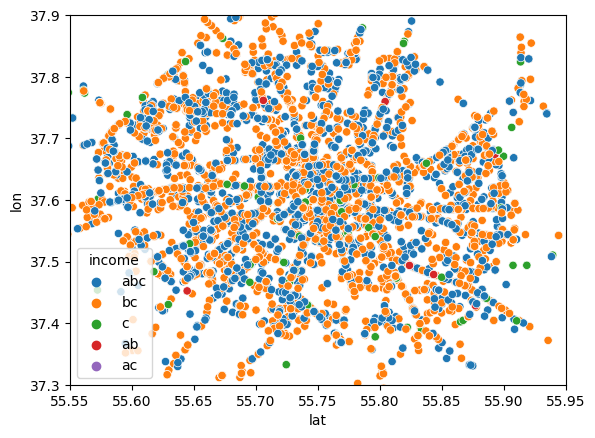

In [287]:
fig, ax = plt.subplots()
sns.scatterplot(
    x=location_data['lat'],
    y=location_data['lon'],
    ax=ax, hue=location_data['income']
)
ax.set_ylim(37.3, 37.9)
ax.set_xlim(55.55, 55.95)
plt.show()

## Разброс возраста

Посмотрим на разброс возрастов в различных группах

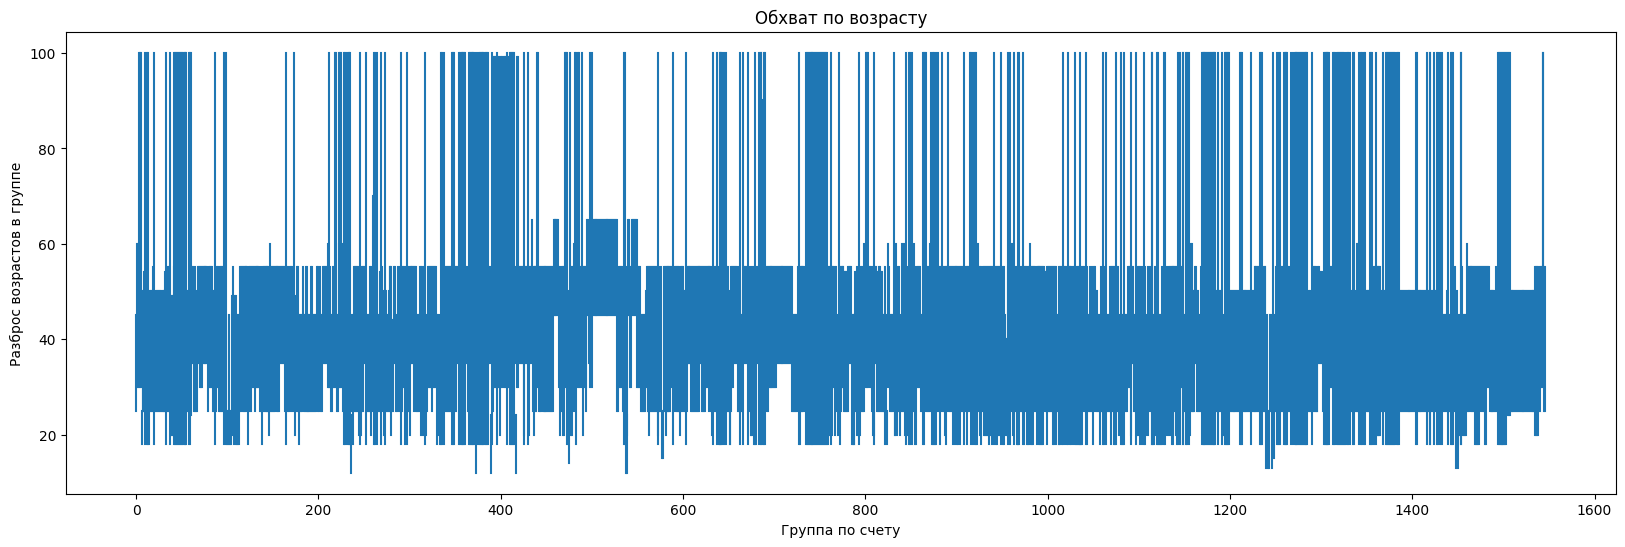

In [23]:
plt.figure(figsize=(20, 6))
for y in range(len(df)):
    x = [df['ageFrom'].iloc[y], df['ageTo'].iloc[y]]
    plt.plot([y] * 2, x, color=(31 / 255, 119 / 255, 180 / 255))

plt.title('Обхват по возрасту')
plt.xlabel('Группа по счету')
plt.ylabel('Разброс возрастов в группе')
plt.show()

Distribution of the number of points in marketing campaigns 

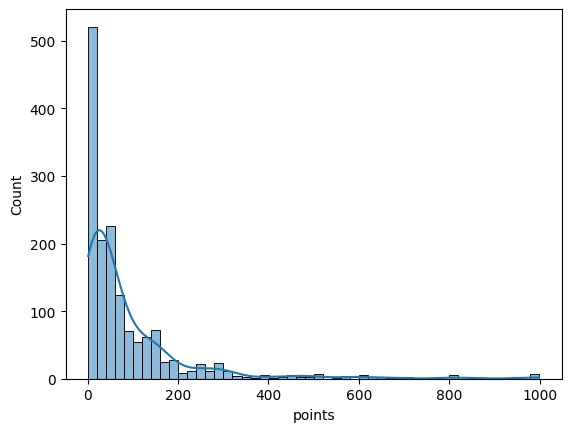

In [70]:
sns.histplot(df['points'].apply(lambda l: len(l)), kde=True, bins=50)
plt.show()

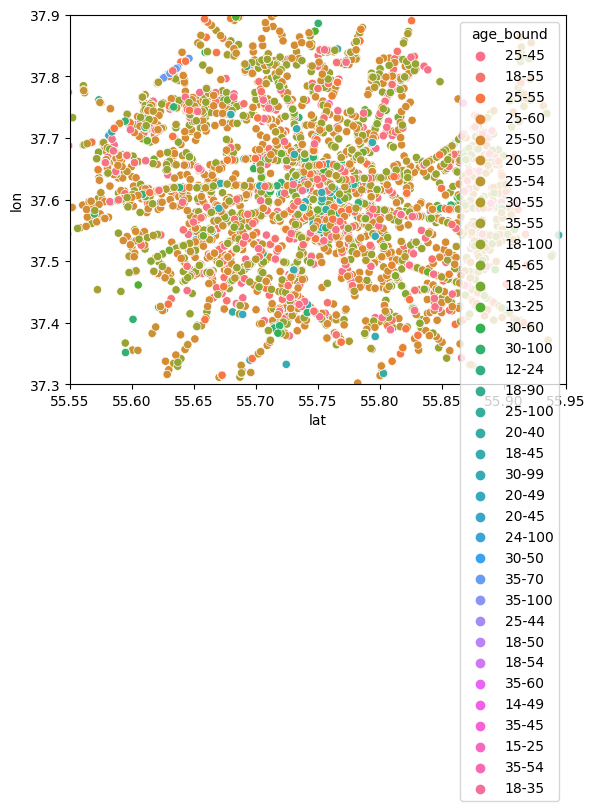

In [272]:
fig, ax = plt.subplots()
sns.scatterplot(
    x=location_data['lat'], y=location_data['lon'],
    ax=ax, hue=location_data['age_bound']
)
ax.set_ylim(37.3, 37.9)
ax.set_xlim(55.55, 55.95)
plt.show()

## Разброс в точках разных групп

In [250]:
clustering = DBSCAN(eps=0.5, min_samples=5).fit(location_data[['lat', 'lon']])
# clustering = KMeans(n_clusters=11, random_state=42).fit(location_data)

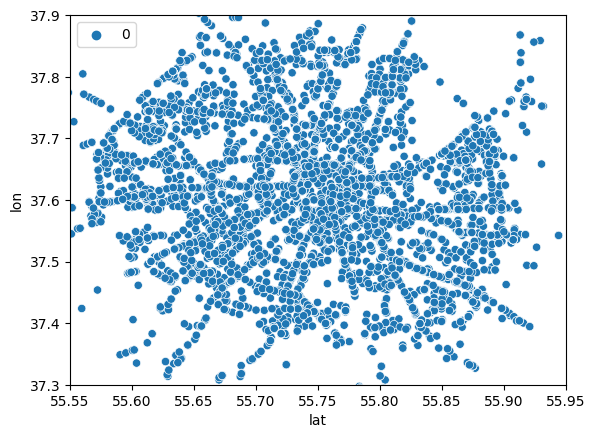

In [251]:
fig, ax = plt.subplots()
sns.scatterplot(
    x=location_data['lat'], y=location_data['lon'],
    ax=ax, hue=clustering.labels_
)
ax.set_ylim(37.3, 37.9)
ax.set_xlim(55.55, 55.95)
plt.show()

In [25]:
def plot_points(df, images_per_row=5, centering=False):
    num_rows = len(df) // images_per_row + int(len(df) % images_per_row != 0)
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))

    for i in range(num_rows * images_per_row):
        if i < len(df):
            ax = axes.flat[i]

            g = df.iloc[i]
            points = np.array([[float(x['lat']), float(x['lon'])] for x in g['points']])
            ax.scatter(points[:, 0], points[:, 1])
            ax.axis('on')

            ax.set_title(f"{g['name']} | {g['gender']} | {g['value']} | {np.round(g['value'] / len(points), 2)}")

            if centering:
                #большинство точек находится в этом диапазоне
                ax.set_ylim(37.3, 37.9)
                ax.set_xlim(55.55, 55.95)
        else:
            axes.flat[i].axis('off')

    plt.tight_layout()
    plt.show()

Визуализируем географическое расположение точек

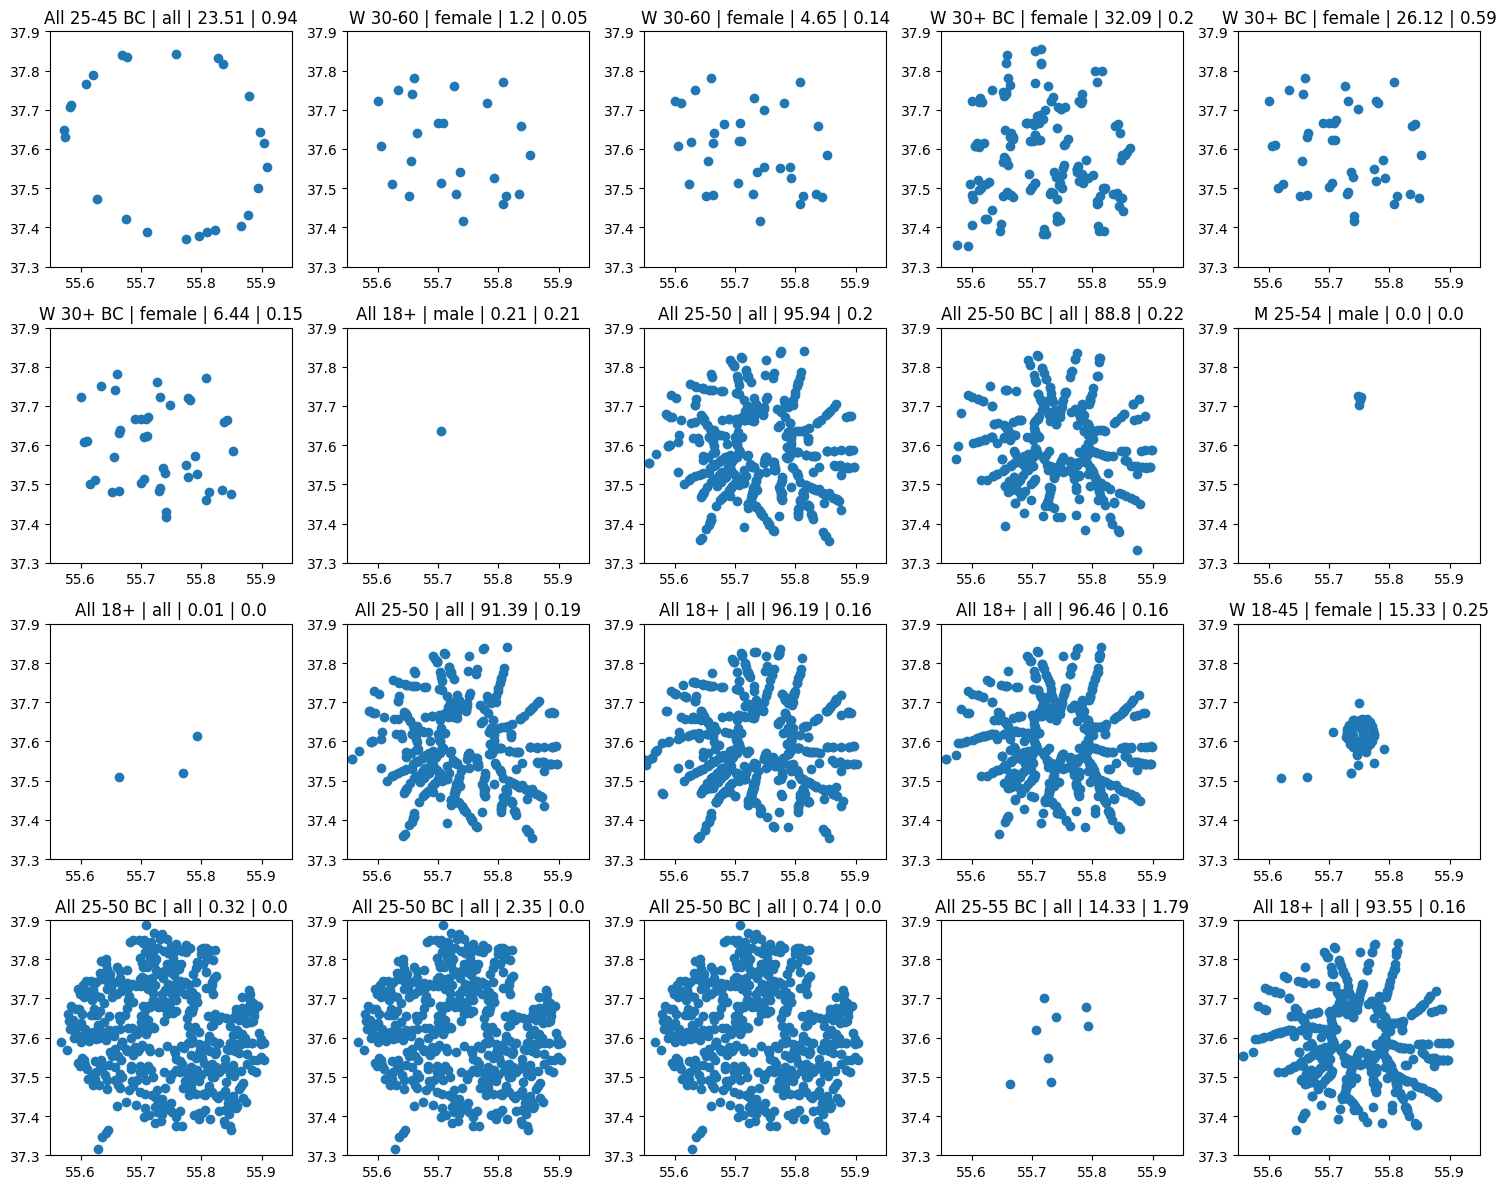

In [26]:
# Группа | пол | охват | охват каждой точки в среднем
plot_points(df.iloc[:20], centering=True)

#ML

## Создание датасета

Разделим поле точек на регионы и будем считать сколько точек вошло в каждый регион



![](https://sun9-54.userapi.com/impg/QBVBqxSazAvK14qcnHvlbIBYY5LyWgDuyz-jKw/-jZvbdc65xU.jpg?size=1559x671&quality=96&sign=ea433b49256854e166845059f3048790&type=album)

In [27]:
#Делит отрезок на равные интервалы
def split_on_intervals(min_val, max_val, n):
    step = (max_val - min_val) / n
    intervals = [min_val + (step * x) for x in range(n + 1)]
    return intervals


Дополнительно добавим группы, в которые будут входить точки, не попашие в заданные интервалы x и y

![](https://sun9-50.userapi.com/impg/XGrWApG23xrhfxSrEpJ3FUoiEgLvCRqCeMkq_A/Z69rNRJYVbE.jpg?size=1919x1079&quality=96&sign=ff220aa2d2c72a69d0faaedc5bc3e8c6&type=album)

In [46]:
#Создает регионы для поля
def create_groups(x_intervals, y_intervals):
    groups = {}
    x_intervals = np.concatenate([[-np.inf], x_intervals, [np.inf]])
    y_intervals = np.concatenate([[-np.inf], y_intervals, [np.inf]])

    for x_i in range(len(x_intervals) - 1):
        for y_i in range(len(y_intervals) - 1):
            groups[
                f'x : {x_intervals[x_i]} - {x_intervals[x_i + 1]} | y : {y_intervals[y_i]} - {y_intervals[y_i + 1]}'] = 0

    return groups

In [47]:
#Сортирует точки по регионам
def sort_on_groups(x_vals, y_vals, x_intervals, y_intervals, groups, only_vals=False):
    for x, y in zip(x_vals, y_vals):
        for x_i in range(len(x_intervals) - 1):
            for y_i in range(len(y_intervals) - 1):
                if ((x_intervals[x_i] <= x < x_intervals[x_i + 1]) and (y_intervals[y_i] <= y < y_intervals[y_i + 1])):
                    groups[
                        f'x : {x_intervals[x_i]} - {x_intervals[x_i + 1]} | y : {y_intervals[y_i]} - {y_intervals[y_i + 1]}'] += 1

    if only_vals:
        return list(groups.values())

    return groups

In [289]:
def create_dataset(config, df):
    x_intervals = split_on_intervals(config['min_xval'], config['max_xval'], config['x_ngroups'])
    y_intervals = split_on_intervals(config['min_yval'], config['max_yval'], config['y_ngroups'])

    groups = create_groups(x_intervals, y_intervals)

    groups_values = []

    for i in range(len(df)):
        g = df.iloc[i]
        points = np.array([[float(x['lat']), float(x['lon'])] for x in g['points']])

        group_values = sort_on_groups(points[:, 0], points[:, 1], x_intervals, y_intervals, groups.copy(), only_vals=True)
        groups_values.append(group_values)

    groups_values = np.array(groups_values)

    for i in range(len(groups.keys())):
        groups[list(groups.keys())[i]] = groups_values[:, i]

    return groups


In [290]:
config = {'min_xval': 55.55, 'max_xval': 55.95, 'min_yval': 37.3, 'max_yval': 37.9, 'x_ngroups': 3, 'y_ngroups': 3}

In [291]:
dataset = pd.DataFrame(create_dataset(config, df))

[55.55, 55.68333333333333, 55.81666666666667, 55.95]


In [288]:
dataset

,x : -inf - 55.55 | y : -inf - 37.3,x : -inf - 55.55 | y : 37.3 - 37.5,x : -inf - 55.55 | y : 37.5 - 37.699999999999996,x : -inf - 55.55 | y : 37.699999999999996 - 37.9,x : -inf - 55.55 | y : 37.9 - inf,x : 55.55 - 55.68333333333333 | y : -inf - 37.3,x : 55.55 - 55.68333333333333 | y : 37.3 - 37.5,x : 55.55 - 55.68333333333333 | y : 37.5 - 37.699999999999996,x : 55.55 - 55.68333333333333 | y : 37.699999999999996 - 37.9,x : 55.55 - 55.68333333333333 | y : 37.9 - inf,...,x : 55.81666666666667 - 55.95 | y : -inf - 37.3,x : 55.81666666666667 - 55.95 | y : 37.3 - 37.5,x : 55.81666666666667 - 55.95 | y : 37.5 - 37.699999999999996,x : 55.81666666666667 - 55.95 | y : 37.699999999999996 - 37.9,x : 55.81666666666667 - 55.95 | y : 37.9 - inf,x : 55.95 - inf | y : -inf - 37.3,x : 55.95 - inf | y : 37.3 - 37.5,x : 55.95 - inf | y : 37.5 - 37.699999999999996,x : 55.95 - inf | y : 37.699999999999996 - 37.9,x : 55.95 - inf | y : 37.9 - inf
0,0,0,0,0,0,0,2,2,6,0,...,0,4,3,3,0,0,0,0,0,0
1,0,0,0,0,0,0,1,4,4,0,...,0,1,2,0,0,0,0,0,0,0
2,0,0,0,0,0,0,2,7,4,0,...,0,2,2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,16,22,13,0,...,0,10,10,0,0,0,0,0,0,0
4,0,0,0,0,0,0,2,7,4,0,...,0,2,3,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,0,0,0,0,0,0,1,2,5,0,...,0,5,2,1,0,0,0,0,0,0
1543,0,0,0,0,0,0,6,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1544,0,0,0,0,0,0,6,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1545,0,0,0,0,0,0,2,4,4,0,...,0,4,4,0,0,0,0,0,0,0


все получившиеся группы

In [51]:
dataset.columns

Index(['x : -inf - 55.55 | y : -inf - 37.3',
       'x : -inf - 55.55 | y : 37.3 - 37.5',
       'x : -inf - 55.55 | y : 37.5 - 37.699999999999996',
       'x : -inf - 55.55 | y : 37.699999999999996 - 37.9',
       'x : -inf - 55.55 | y : 37.9 - inf',
       'x : 55.55 - 55.68333333333333 | y : -inf - 37.3',
       'x : 55.55 - 55.68333333333333 | y : 37.3 - 37.5',
       'x : 55.55 - 55.68333333333333 | y : 37.5 - 37.699999999999996',
       'x : 55.55 - 55.68333333333333 | y : 37.699999999999996 - 37.9',
       'x : 55.55 - 55.68333333333333 | y : 37.9 - inf',
       'x : 55.68333333333333 - 55.81666666666667 | y : -inf - 37.3',
       'x : 55.68333333333333 - 55.81666666666667 | y : 37.3 - 37.5',
       'x : 55.68333333333333 - 55.81666666666667 | y : 37.5 - 37.699999999999996',
       'x : 55.68333333333333 - 55.81666666666667 | y : 37.699999999999996 - 37.9',
       'x : 55.68333333333333 - 55.81666666666667 | y : 37.9 - inf',
       'x : 55.81666666666667 - 55.95 | y : -inf - 37.

Изначальные поля точек, перестроенные под количество вхождений в группу

In [52]:
dataset.head()

,x : -inf - 55.55 | y : -inf - 37.3,x : -inf - 55.55 | y : 37.3 - 37.5,x : -inf - 55.55 | y : 37.5 - 37.699999999999996,x : -inf - 55.55 | y : 37.699999999999996 - 37.9,x : -inf - 55.55 | y : 37.9 - inf,x : 55.55 - 55.68333333333333 | y : -inf - 37.3,x : 55.55 - 55.68333333333333 | y : 37.3 - 37.5,x : 55.55 - 55.68333333333333 | y : 37.5 - 37.699999999999996,x : 55.55 - 55.68333333333333 | y : 37.699999999999996 - 37.9,x : 55.55 - 55.68333333333333 | y : 37.9 - inf,...,x : 55.81666666666667 - 55.95 | y : -inf - 37.3,x : 55.81666666666667 - 55.95 | y : 37.3 - 37.5,x : 55.81666666666667 - 55.95 | y : 37.5 - 37.699999999999996,x : 55.81666666666667 - 55.95 | y : 37.699999999999996 - 37.9,x : 55.81666666666667 - 55.95 | y : 37.9 - inf,x : 55.95 - inf | y : -inf - 37.3,x : 55.95 - inf | y : 37.3 - 37.5,x : 55.95 - inf | y : 37.5 - 37.699999999999996,x : 55.95 - inf | y : 37.699999999999996 - 37.9,x : 55.95 - inf | y : 37.9 - inf
0,0,0,0,0,0,0,2,2,6,0,...,0,4,3,3,0,0,0,0,0,0
1,0,0,0,0,0,0,1,4,4,0,...,0,1,2,0,0,0,0,0,0,0
2,0,0,0,0,0,0,2,7,4,0,...,0,2,2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,16,22,13,0,...,0,10,10,0,0,0,0,0,0,0
4,0,0,0,0,0,0,2,7,4,0,...,0,2,3,0,0,0,0,0,0,0


Визуализируем полученные поля с группами

In [53]:
def plot_fields(df, field_size, images_per_row=5):
    num_rows = len(df) // images_per_row + int(len(df) % images_per_row != 0)
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))

    for i in range(num_rows * images_per_row):
        if i < len(df):
            ax = axes.flat[i]

            data = df.iloc[i].values.reshape(field_size)

            ax.imshow(data, cmap="Blues", interpolation='nearest')
            ax.axis('off')

            for i in range(field_size[0]):
                for j in range(field_size[1]):
                    text = ax.text(j, i, f'{data[i, j]}', ha='center', va='center', color='white')
                    text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])


        else:
            axes.flat[i].axis('off')

    plt.tight_layout()
    plt.show()

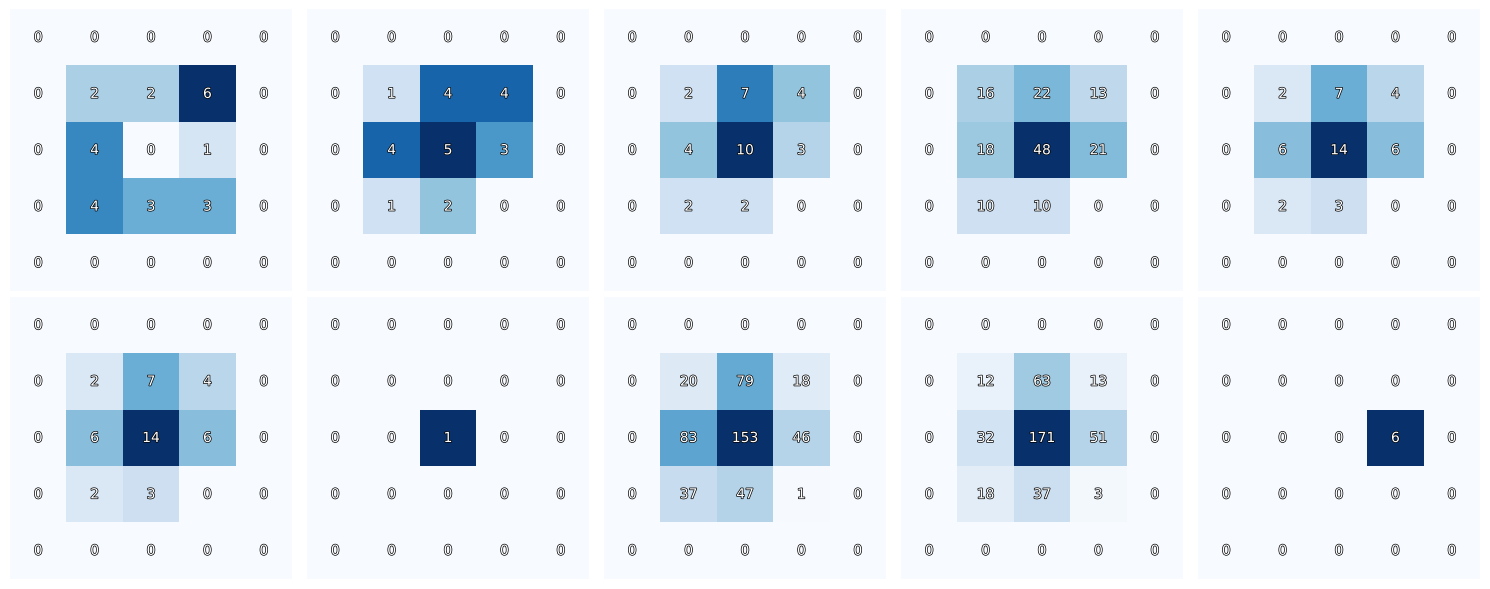

In [54]:
field_size = (config['x_ngroups'] + 2, config['y_ngroups'] + 2)  # +2 т.к добавляются группы с + и - бесконечностями
plot_fields(dataset[:10], field_size, images_per_row=5)

## Создание модели

In [55]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

In [64]:
X

,x : -inf - 55.55 | y : -inf - 37.3,x : -inf - 55.55 | y : 37.3 - 37.5,x : -inf - 55.55 | y : 37.5 - 37.699999999999996,x : -inf - 55.55 | y : 37.699999999999996 - 37.9,x : -inf - 55.55 | y : 37.9 - inf,x : 55.55 - 55.68333333333333 | y : -inf - 37.3,x : 55.55 - 55.68333333333333 | y : 37.3 - 37.5,x : 55.55 - 55.68333333333333 | y : 37.5 - 37.699999999999996,x : 55.55 - 55.68333333333333 | y : 37.699999999999996 - 37.9,x : 55.55 - 55.68333333333333 | y : 37.9 - inf,...,x : 55.81666666666667 - 55.95 | y : -inf - 37.3,x : 55.81666666666667 - 55.95 | y : 37.3 - 37.5,x : 55.81666666666667 - 55.95 | y : 37.5 - 37.699999999999996,x : 55.81666666666667 - 55.95 | y : 37.699999999999996 - 37.9,x : 55.81666666666667 - 55.95 | y : 37.9 - inf,x : 55.95 - inf | y : -inf - 37.3,x : 55.95 - inf | y : 37.3 - 37.5,x : 55.95 - inf | y : 37.5 - 37.699999999999996,x : 55.95 - inf | y : 37.699999999999996 - 37.9,x : 55.95 - inf | y : 37.9 - inf
0,0,0,0,0,0,0,2,2,6,0,...,0,4,3,3,0,0,0,0,0,0
1,0,0,0,0,0,0,1,4,4,0,...,0,1,2,0,0,0,0,0,0,0
2,0,0,0,0,0,0,2,7,4,0,...,0,2,2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,16,22,13,0,...,0,10,10,0,0,0,0,0,0,0
4,0,0,0,0,0,0,2,7,4,0,...,0,2,3,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,0,0,0,0,0,0,1,2,5,0,...,0,5,2,1,0,0,0,0,0,0
1543,0,0,0,0,0,0,6,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1544,0,0,0,0,0,0,6,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1545,0,0,0,0,0,0,2,4,4,0,...,0,4,4,0,0,0,0,0,0,0


In [56]:
X = dataset
y = df['value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
model = CatBoostRegressor(iterations=1000,
                          depth=6,
                          learning_rate=0.05,
                          loss_function='RMSE')

model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)

0:	learn: 23.5570296	test: 21.6750802	best: 21.6750802 (0)	total: 1.22ms	remaining: 1.22s
100:	learn: 11.4750354	test: 11.4338414	best: 11.4338414 (100)	total: 44.4ms	remaining: 396ms
200:	learn: 9.1706774	test: 10.1946650	best: 10.1946650 (200)	total: 82.9ms	remaining: 329ms
300:	learn: 7.9377627	test: 9.5178333	best: 9.5174184 (299)	total: 123ms	remaining: 286ms
400:	learn: 7.1044550	test: 9.1007045	best: 9.1007045 (400)	total: 162ms	remaining: 242ms
500:	learn: 6.5068127	test: 8.8426256	best: 8.8422322 (498)	total: 203ms	remaining: 202ms
600:	learn: 6.0701606	test: 8.6894279	best: 8.6879826 (598)	total: 238ms	remaining: 158ms
700:	learn: 5.7458090	test: 8.6095180	best: 8.6095180 (700)	total: 278ms	remaining: 119ms
800:	learn: 5.4828172	test: 8.5668154	best: 8.5646444 (783)	total: 316ms	remaining: 78.5ms
900:	learn: 5.2742573	test: 8.5246393	best: 8.5246393 (900)	total: 357ms	remaining: 39.3ms
999:	learn: 5.1108922	test: 8.5197608	best: 8.5188275 (998)	total: 396ms	remaining: 0us

be

In [58]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [59]:
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'RMSE: {rmse:.4f}')
print(f'R²: {r2:.4f}')
print(f'MAE: {mae:.4f}')

RMSE: 8.5188
R²: 0.8518
MAE: 5.6649


/Users/filin_va/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#Тестирование

In [60]:
def show_predictions(y_test, y_pred):
    for yt, yp in zip(y_test, y_pred):
        print(f'{yt} | {yp}')

In [61]:
slice_idx = 10

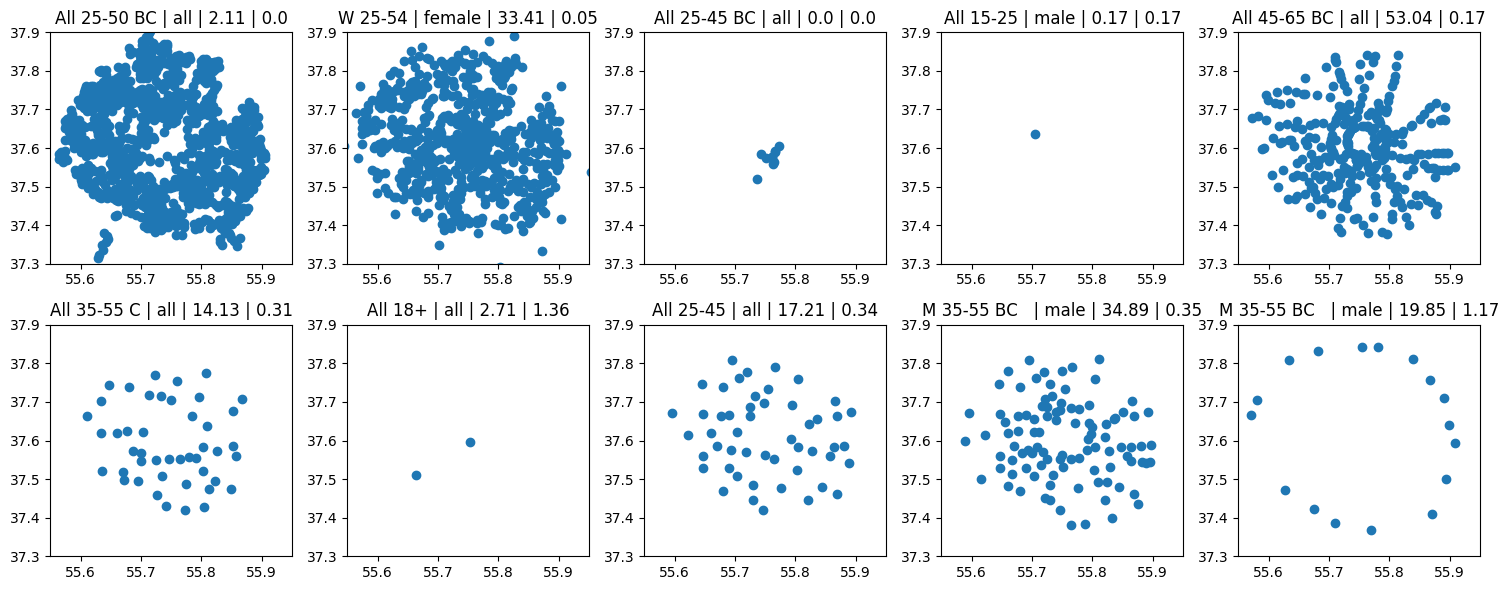

In [62]:
plot_points(df.iloc[y_test.index[:slice_idx]], centering=True)

In [63]:
y_pred = np.round(y_pred, 2)
show_predictions(y_test[:slice_idx], y_pred[:slice_idx])

2.11 | 1.58
33.41 | 15.72
0.0 | 6.21
0.17 | 1.45
53.04 | 58.78
14.13 | 18.25
2.71 | 0.84
17.21 | 7.48
34.89 | 26.81
19.85 | 12.42
